<a href="https://colab.research.google.com/github/lukasztracz195/DeepLearningInPythonCourse/blob/main/kvasir_dataset_VGG16_transfer_learning_fix_issue_with_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wykorzystanie już wytrenowanego modelu VGG16 do klasyfikacji datasetu kvasir

#1. Przygotowanie środowiska

##1.1 Sprawdzenie wersji pythona zainstalowanej na serwerze Google Colaboratory

In [1]:
!python --version

Python 3.7.12


##1.2 Instalcja odpowiedniej wersji pakietu Tensorflow


In [2]:
#To determine which version you're using:
!pip show tensorflow

# For a specific version:
!pip install tensorflow==2.4.1

Name: tensorflow
Version: 2.6.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: h5py, clang, keras, google-pasta, wheel, grpcio, numpy, six, tensorboard, termcolor, astunparse, typing-extensions, flatbuffers, tensorflow-estimator, protobuf, wrapt, opt-einsum, absl-py, gast, keras-preprocessing
Required-by: kapre
     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 3.8 MB 38.3 MB/s 
     |████████████████████████████████| 462 kB 48.5 MB/s 
     |████████████████████████████████| 2.9 MB 41.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.40.0
    Uninstalling grpcio-1.40.0:
      Successfully uninstalled grpcio-1.40.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-est

##1.3 Instalcja odpowiedniej wersji pakietu keras

In [6]:
!pip3 install keras==2.4.3
!pip3 show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, h5py, pyyaml, scipy
Required-by: keras-vis


##1.4 Podłączenie się do dysku Google (Obcjonalne by móc zapisywać utworzone pliki)


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# 2. Przygotowanie danych

##2.1 Zdefiniowanie linków do datasetów kvasir

In [7]:
kvasir_dataset_v1 = "https://datasets.simula.no/kvasir/data/kvasir-dataset.zip"
extracted_features_kvasir_dataset_v1 = "https://datasets.simula.no/kvasir/data/kvasir-dataset-features.zip"
kvasir_datset_v2 = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"
extracted_features_kvasir_dataset_v2 = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-features.zip"
kvasir_dataset_v2_folds = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds.zip"
extracted_features_kvasir_dataset_v2_folds = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds-features.zip"
kvasir_dataset_v2_folds_additional_set = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds-additional-classes.zip"
extracted_features_kvasir_dataset_v2_folds_additional_set = "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds-additional-classes-features.zip"

##2.2 Pobranie i rozpakowanie danych kvasir_dataset_v1

In [15]:
!wget -nc {kvasir_datset_v2}
!unzip kvasir-dataset-v2.zip
# !rm -f kvasir-dataset-v2-folds.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus

## 2.3 Sprawdzenie rozmiaru i formatu danych

###2.3.1 Przygotowanie funkcji do sprawdzenia rozmiaru obrazu

In [16]:
def get_set_sizes_of_images_and_extesions_in_exist_in_location(path_to_directory_with_images):
    import os
    import cv2
    from os import listdir
    set_of_sizes = set()
    set_of_extensions = set()
    for filename_with_extension in listdir(path_to_directory_with_images):
        filename_extension_tuple = os.path.splitext(filename_with_extension)
        filename = filename_extension_tuple[0]
        extension = filename_extension_tuple[1]
        path = path_to_directory_with_images + "/" + filename_with_extension
        image_data = cv2.imread(path)
        if image_data.shape not in set_of_sizes:
            set_of_sizes.add(image_data.shape)
        if extension not in set_of_extensions:
            set_of_extensions.add(extension)
    return set_of_sizes, set_of_extensions

###2.3.2 Sprawdzenie jakimi rozmiarami i formatami obrazów dysponujemy

In [18]:
global_path = "/content"
path_to_dataset = "kvasir-dataset-v2"
classes = ["dyed-lifted-polyps", "dyed-resection-margins", "esophagitis", "normal-cecum", "normal-pylorus", "normal-z-line", "polyps", "ulcerative-colitis"]
for class_name in classes:
    path_to_directory  = global_path + "/" + path_to_dataset + "/" + class_name
    set_of_sizes, set_of_extensions = get_set_sizes_of_images_and_extesions_in_exist_in_location(path_to_directory)
    message = "class_name_directory: %s | sizes_of_size_images: %s | extensions: %s" % (class_name, set_of_sizes, set_of_extensions)
    print(message)

class_name_directory: dyed-lifted-polyps | sizes_of_size_images: {(1080, 1350, 3), (1072, 1920, 3), (1064, 1350, 3), (576, 720, 3)} | extensions: {'.jpg'}
class_name_directory: dyed-resection-margins | sizes_of_size_images: {(1072, 1920, 3), (576, 720, 3)} | extensions: {'.jpg'}
class_name_directory: esophagitis | sizes_of_size_images: {(576, 720, 3), (1072, 1920, 3), (1024, 1280, 3)} | extensions: {'.jpg'}
class_name_directory: normal-cecum | sizes_of_size_images: {(576, 720, 3)} | extensions: {'.jpg'}
class_name_directory: normal-pylorus | sizes_of_size_images: {(576, 720, 3), (1072, 1920, 3), (1024, 1280, 3)} | extensions: {'.jpg'}
class_name_directory: normal-z-line | sizes_of_size_images: {(576, 720, 3), (1072, 1920, 3), (1024, 1280, 3)} | extensions: {'.jpg'}
class_name_directory: polyps | sizes_of_size_images: {(1072, 1920, 3), (1064, 1350, 3), (1024, 1280, 3), (576, 720, 3)} | extensions: {'.jpg'}
class_name_directory: ulcerative-colitis | sizes_of_size_images: {(1024, 1280, 3)

### 2.3.2 Dane jakimi dysponujemy wyamgają ujednolicenia ich do tego samego rozmiaru by móc ich użyć w modelu sieci neuronowej

##2.4 Zmiana rozmiarów obrazów w datasecie

###2.4.1 Utowrzenie funckji do zmainy rozmiaru obrazu

In [19]:
def resize_image(src_img, target_size=(64,64), bg_color="black", color_format="RGB"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(target_size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new(color_format, target_size, bg_color)

    # Paste the rescaled image onto the new centered background
    new_image.paste(src_img, (int((target_size[0] - src_img.size[0]) / 2), int((target_size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

###2.4.2 Zmiana rozmiaru obrazów na żadany w datasecie

In [20]:
TARGET_SIZE = (600,600)

In [21]:
from PIL import Image
from os import listdir

for class_name in classes:
    path_to_directory  = global_path + "/" + path_to_dataset + "/" + class_name
    for filename_with_extension in listdir(path_to_directory):
        path_to_image  = global_path + "/" + path_to_dataset + "/" + class_name + "/" + filename_with_extension
        img = Image.open(path_to_image)
        resized_img = resize_image(img, target_size=TARGET_SIZE)
        resized_img.save(path_to_image)

###2.4.3 Sprawdzenie czy zmiana rozmiaru danych się powiodła

In [22]:
for class_name in classes:
    path_to_directory  = global_path + "/" + path_to_dataset + "/" + class_name
    set_of_sizes, set_of_extensions = get_set_sizes_of_images_and_extesions_in_exist_in_location(path_to_directory)
    message = "class_name_directory: %s | sizes_of_size_images: %s | extensions: %s" % (class_name, set_of_sizes, set_of_extensions)
    print(message)

class_name_directory: dyed-lifted-polyps | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: dyed-resection-margins | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: esophagitis | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: normal-cecum | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: normal-pylorus | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: normal-z-line | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: polyps | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}
class_name_directory: ulcerative-colitis | sizes_of_size_images: {(600, 600, 3)} | extensions: {'.jpg'}


###2.5 Podział danych na treningowe i testowe

In [23]:
import os
import numpy as np
import shutil
import random
root_dir = global_path + "/" + path_to_dataset + "/"
classes_dir = ["dyed-lifted-polyps", "dyed-resection-margins", "esophagitis", "normal-cecum", "normal-pylorus", "normal-z-line", "polyps", "ulcerative-colitis"]

test_ratio = 0.20

for cls in classes_dir:
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

src = root_dir + cls

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print("*****************************")
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))
print("*****************************")


lab = classes_dir

for name in train_FileNames:
    for i in lab:
        shutil.copy(name, root_dir +'train/' + i)

for name in test_FileNames:
    for i in lab:
        shutil.copy(name, root_dir +'test/' + i)
print("Copying Done!")

*****************************
Total images:  1000
Training:  800
Testing:  200
*****************************
Copying Done!


## 2.6 Przygotowanie datasetu zgodnie z api kerasa

In [24]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

root_dir = global_path + "/" + path_to_dataset + "/"

train_ds = image_dataset_from_directory(
    directory=root_dir + "train/",
    labels='inferred',
    color_mode="rgb",
    label_mode='categorical',
    batch_size=32,
    image_size=TARGET_SIZE)
test_ds = image_dataset_from_directory(
    directory=root_dir + "test/",
    color_mode="rgb",
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=TARGET_SIZE)

Found 6400 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.


#3. Opracowywanie modelu sieci neuronowej bazując na VGG16

##3.1 Przygotowanie modelu wytrenowanej już sieci VGG16

In [29]:
import os
import numpy as np
import random

import keras
from keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB7
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

vgg = EfficientNetB7(weights='imagenet')
vgg.summary()

268328960/268326632 [==============================] - 9s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
__________________

##3.2 Zmiana warstwy wyjściowej sieci EfficientNetB7 by zwracała 8 klas

In [30]:
input_shape = (TARGET_SIZE[0],TARGET_SIZE[1],3)
nClasses = 8
print("INPUT_SHAPE: ", input_shape)
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(nClasses, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)
model_new.summary()

INPUT_SHAPE:  (600, 600, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
__________________________________________________________________

##3.3 Wyłączenie trenowania dla warstw sieci VGG16 wszystkich prócz ostatniej

In [31]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

#4 Trenowanie sieci neuronowej

##4.1 Zdefiniowanie callbacków dla naszej sieci

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
my_callbacks = [
    EarlyStopping(monitor='val_loss',min_delta=0.01, patience=10, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_accuracy',min_delta=0.01, patience=10, verbose=1 ,mode='auto')
]

##4.2 Dotrenowywanie naszej sieci VGG16 do naszego problemu

In [33]:
batch_size = 128
epochs = 100_000
history = model_new.fit(train_ds,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_ds,
                    callbacks=my_callbacks)

Epoch 1/100000
200/200 [==============================] - 1524s 7s/step - loss: 2.1832 - accuracy: 0.1176 - val_loss: 2.1033 - val_accuracy: 0.1250
Epoch 2/100000
200/200 [==============================] - ETA: 0s - loss: 2.1606 - accuracy: 0.1151

KeyboardInterrupt: ignored

#5. Przegląd wyników uczenia się naszej sieci

##5.1 Zdefiniowanie funkcji do rysowania wykresów dla funckji straty i funckji dokładności

In [ ]:
def make_accuracy_plot(history):
  
    #   Funckja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym i walidacyjnym.
    

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(10,8))
    plt.plot(epochs, acc, label='Dokladność trenowania', marker='o')
    plt.plot(epochs, val_acc, label='Dokladność walidacji', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history):

    #   Funkjca zwraca wykres straty (loss) modelu na zbiorze treningowym
    #   i walidacyjnym


    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss)+ 1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label="Strata walidacji", marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    plt.show()

## 5.2 Wykres dokładności trenowanie i walidacji

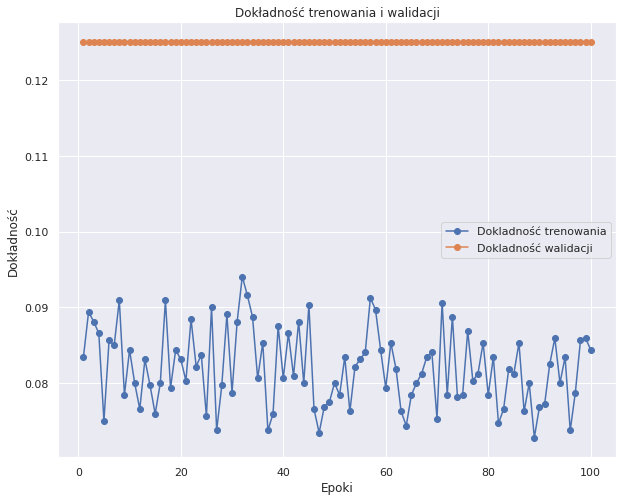

In [ ]:
make_accuracy_plot(history)

##5.3 Wykres straty trenowania i walidacji

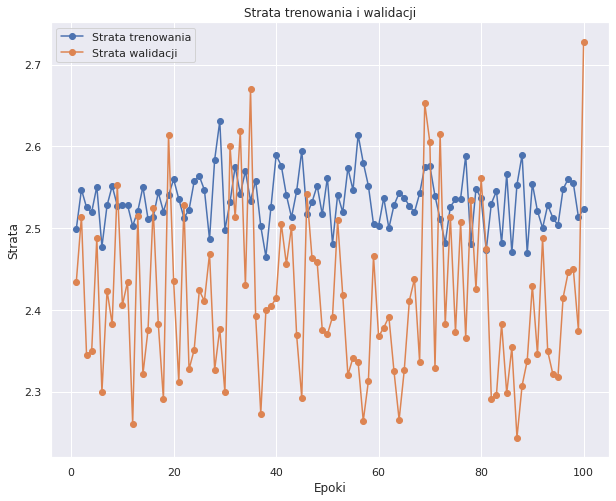

In [ ]:
make_loss_plot(history)